In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score, root_mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR

from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline

In [2]:
# this allows changing the code in external packages and having the changes take effect in the notebook without having to restart the kernel
%load_ext autoreload
%autoreload 2

In [3]:
from smart_fuel_acquisitons.data import create_features_and_targets, \
    create_features_and_targets_on_days_for_month, \
    create_features_and_targets_for_month, \
    predict_until_end, \
    create_features_for_month, create_range_until_month_end, \
    predict_until_month_end, predict_month_avg

In [30]:
config = {
    "MAX_HORIZON": 15,
    "MAX_LAG": 30,
    "SCALER_TYPE": StandardScaler,
    "target_col": 0,
    "models": [
        "Linear",
        "Ridge",
        # "Lasso",
        # "Elastic Net",
        # "Random Forest",
        # "XGBoost",
        # "SVR"
    ],
    "eval_range": ("2020-01-01", "2024-06-01"),
    "window_sizes": [30,60,90],
}

# Tratamento de Dados

In [11]:
# Arquivo Excel
from pathlib import Path
file_path = Path('Dados') / 'ISEG_Bloomberg' / 'Dados.xlsx'
file_path = Path('Dados') / 'Dados_2.xlsx'

In [12]:
# Função para ler e limpar dados de uma folha específica, tratando colunas extras
def read_sheet(sheet_name, col_name):
    data = pd.read_excel(file_path, sheet_name=sheet_name, skiprows=6)
    data = data.iloc[:, [0, 1]]  # Seleciona apenas as duas primeiras colunas relevantes
    data.columns = ['Date', col_name]
    data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
    data = data.dropna().set_index('Date')
    data = data.shift(1).dropna()  # Desloca os preços uma linha para baixo
    return data

Relativamente aos dados presentes em cada folha de Excel deslocou-se uma linha para baixo (close price), porque quando os dados foram extraídos da Bloomberg no dia 17/07/2024 e o dia ainda não tinha terminado, ou seja, o close price do dia 17/07 era o close price do dia anterior e assim sucessivamente, até ao close price mais antigo.

In [13]:
# Ler os dados das várias folhas com os nomes das colunas corrigidos (removendo Brent)
wti_data = read_sheet('WTI Crude Oil', 'WTI Crude Oil Prices')
sp500_data = read_sheet('S&P500', 'S&P500')
gold_data = read_sheet('Gold', 'Gold')
silver_data = read_sheet('Silver', 'Silver')
eurusd_data = read_sheet('EURUSD', 'EUR/USD')
eurrub_data = read_sheet('EURRUB', 'EUR/RUB')

/tmp/ipykernel_801874/2146915167.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Date'] = pd.to_datetime(data['Date'], errors='coerce')


Depois de ter usado todas as variáveis extraídas da Bloomberg e de as ter correlacionado decidi optar apenas por estas, tendo como variável dependente o WTI Crude Oil. O Jet Fuel NWE CIF Cargoes tem, tal como o Brent e como era de esperar, uma correlação de 0.99 com o WTI, no entanto, tem dados apenas desde 2008. A Bitcoin tem dados desde 2010 e tinha uma correlação de 0.10. A taxa de câmbio USD/RUB não tinha dados a partir de 2022 e ambas as moedas estão expostas ao EUR que mostra uma correlação considerável, daí ter optado por retirar do modelo. Por fim, as variáveis total crude oil supply & demand foram retiradas porque, apesar de terem uma correlação aparentemente considerável, têm apenas dados mensais e trimestrais.

In [14]:
# Combinar todas as folhas em um único DataFrame
combined_data = wti_data.join([sp500_data, gold_data, silver_data, eurusd_data, eurrub_data], how='outer')
combined_data.dropna(inplace=True)

## Closing Prices das 6 variáveis s/ Brent

In [15]:
# Exibir os primeiros 5 registros
print(combined_data.head())

           WTI Crude Oil Prices  S&P500    Gold  Silver  EUR/USD  EUR/RUB
Date                                                                     
1994-01-04                 15.3  466.89  393.85    5.24   1.1246   1.1088
1994-01-05                15.36  467.55  391.20    5.09   1.1252   1.1154
1994-01-06                15.33  467.12  388.90    5.12   1.1252   1.1189
1994-01-07                14.65  469.90  387.10    5.01   1.1293   1.1148
1994-01-10                14.95  475.27  384.60    5.04   1.1269   1.1305


## Dados (1994-2024)

In [16]:
# Filtrar os dados entre as datas de 1994 e 2024
start_date = '1994-01-04'
end_date = '2024-07-15'
filtered_data = combined_data[(combined_data.index >= start_date) & (combined_data.index <= end_date)]

In [17]:
# Função para plotar cada variável
def plot_variable(data, variable_name):
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data[variable_name], label=variable_name)
    plt.title(f'{variable_name} (1994 - 2024)')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

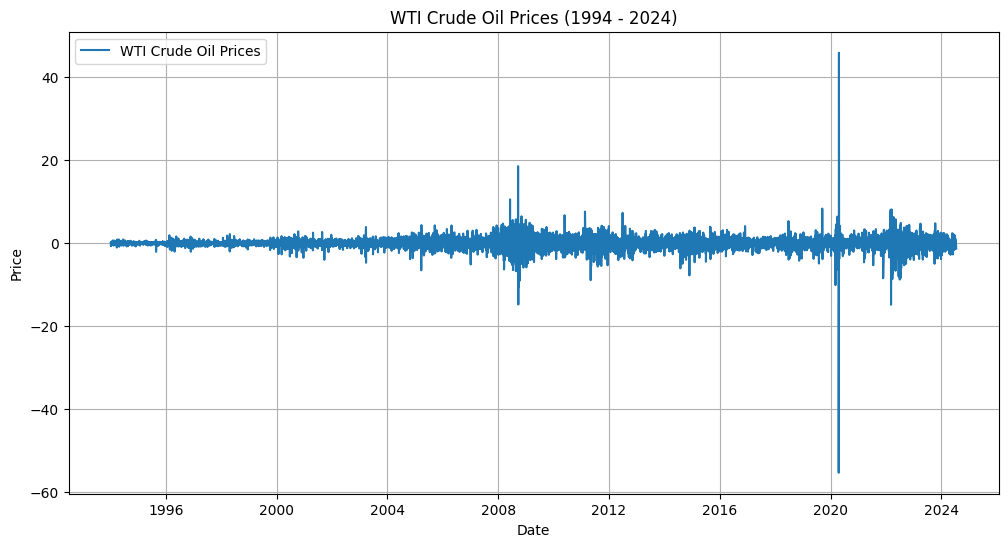

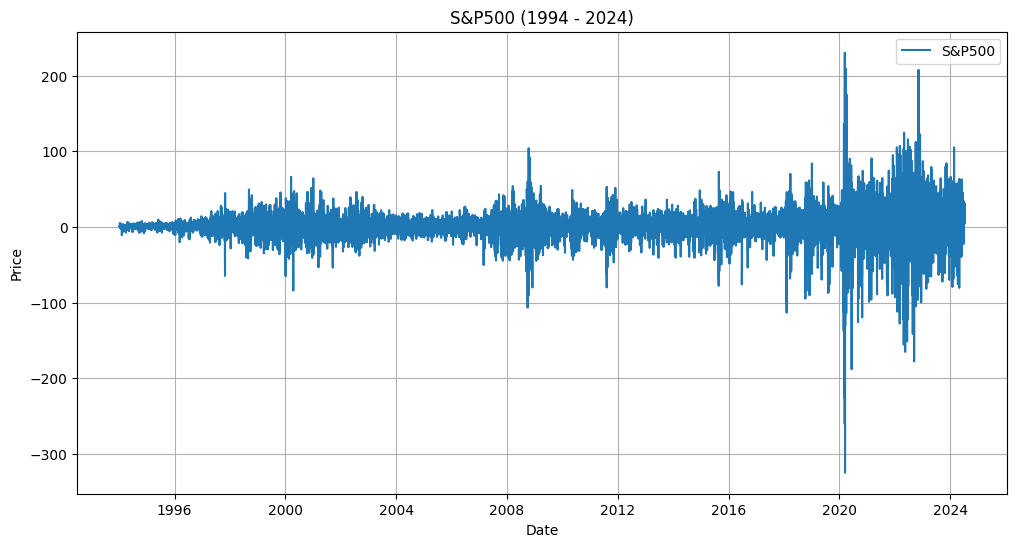

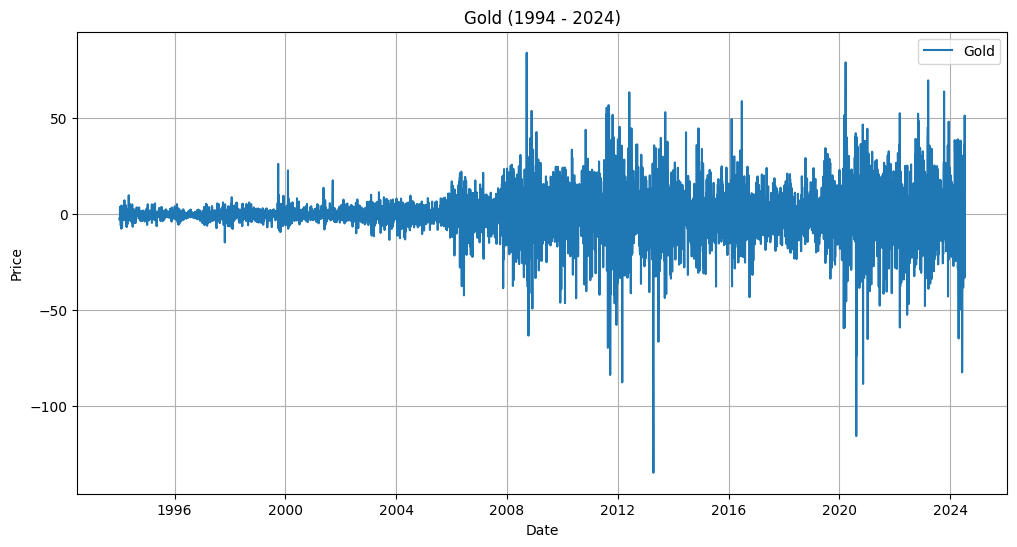

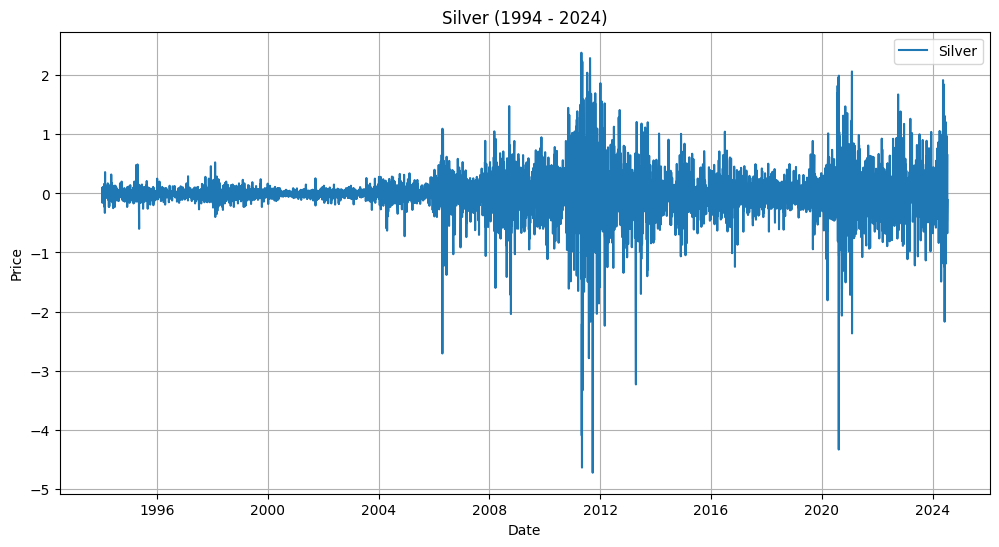

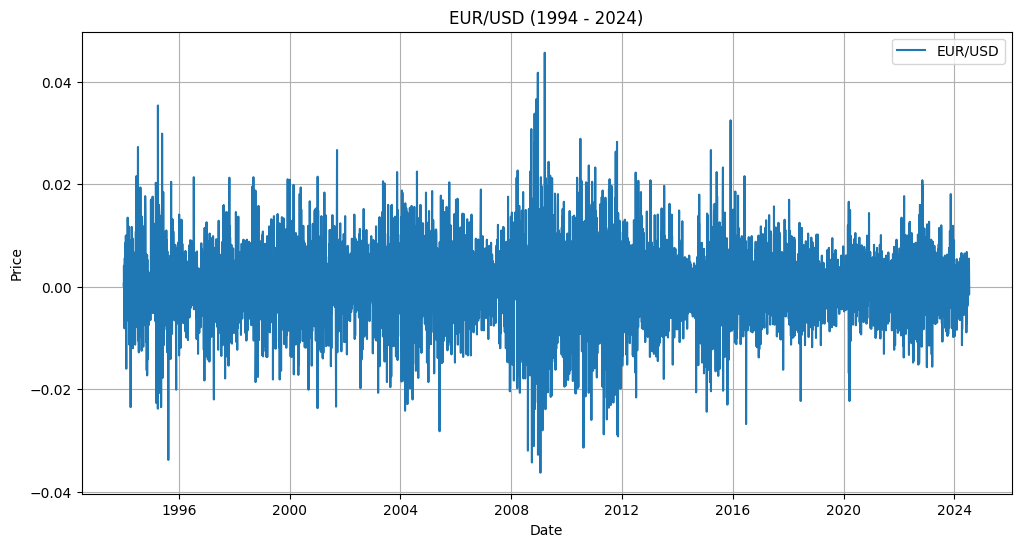

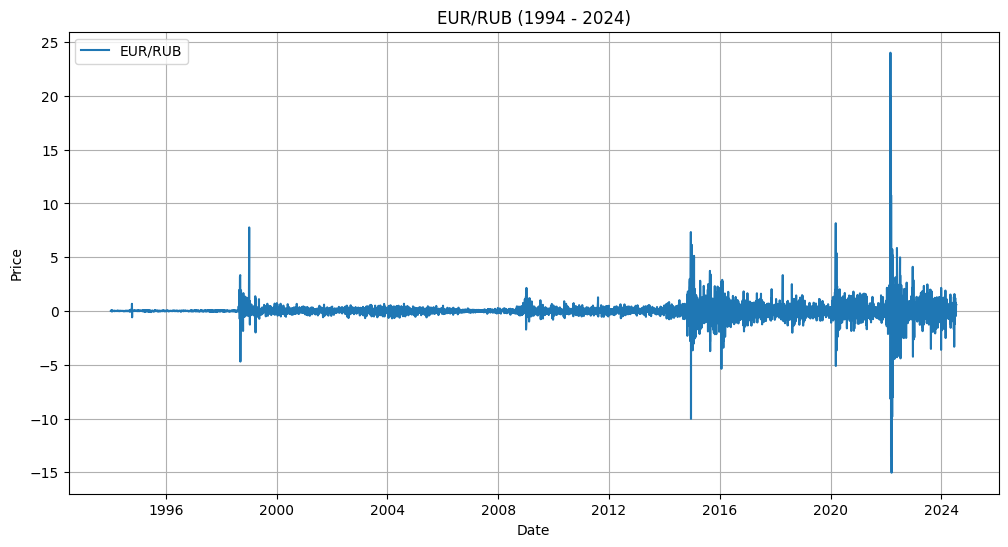

In [18]:
dif_data = filtered_data.diff().dropna()
for col in dif_data.columns:
    plot_variable(dif_data, col)


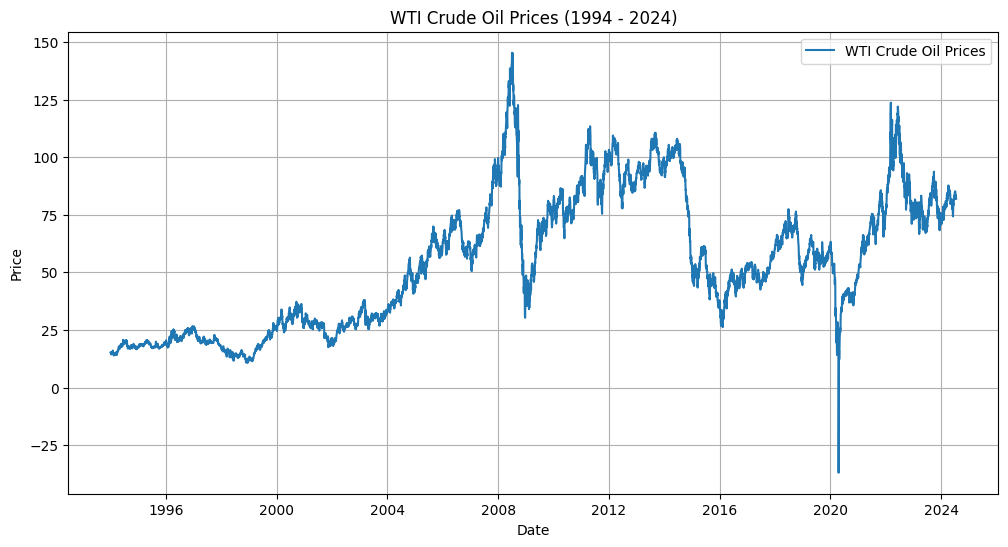

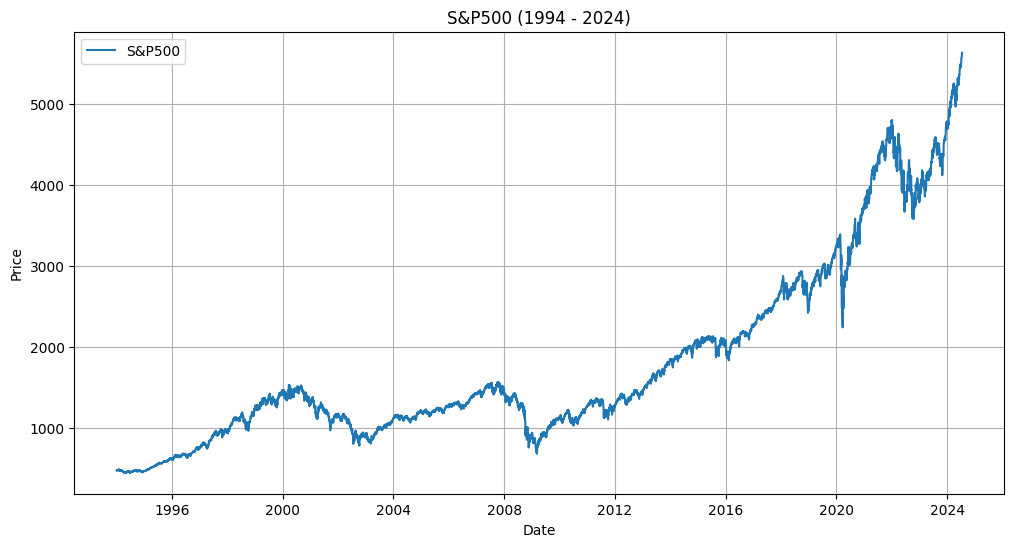

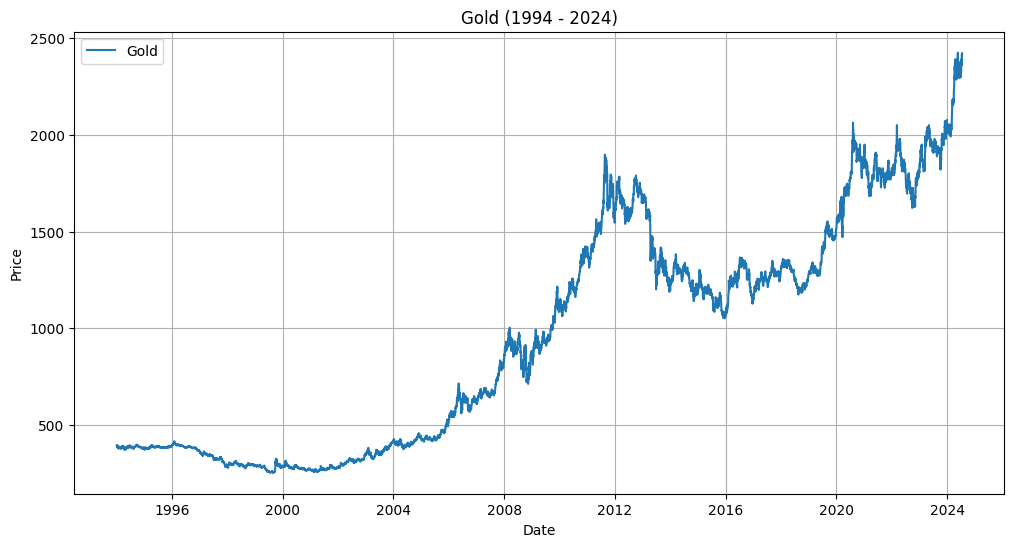

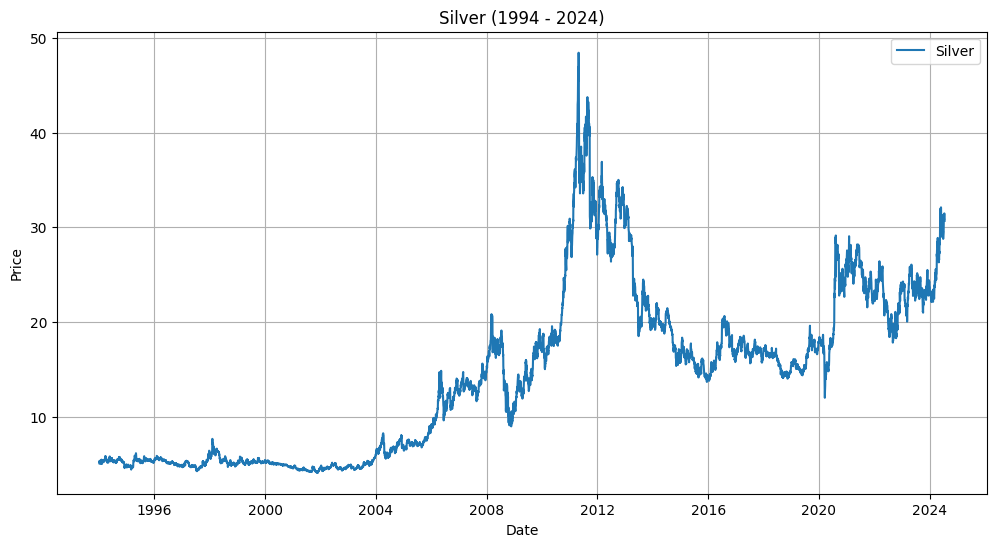

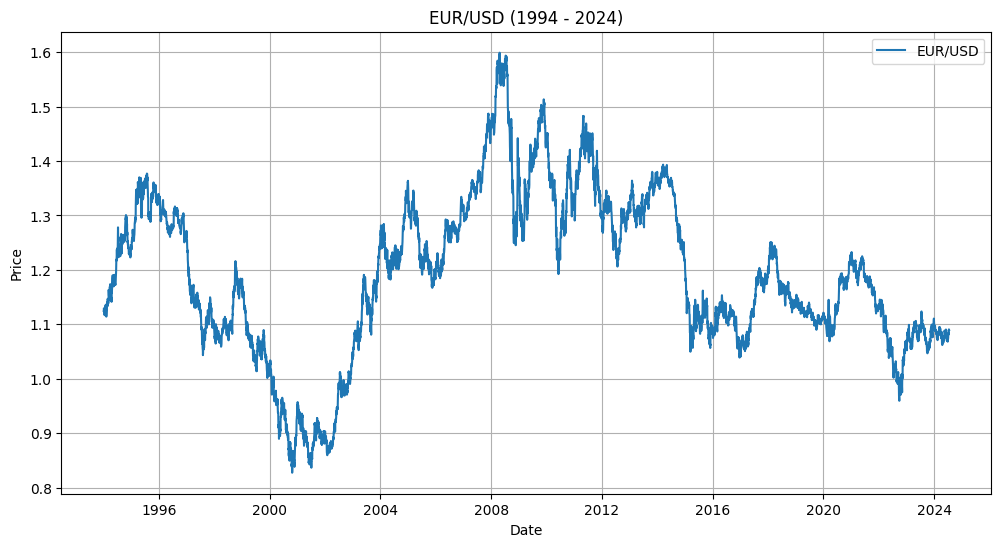

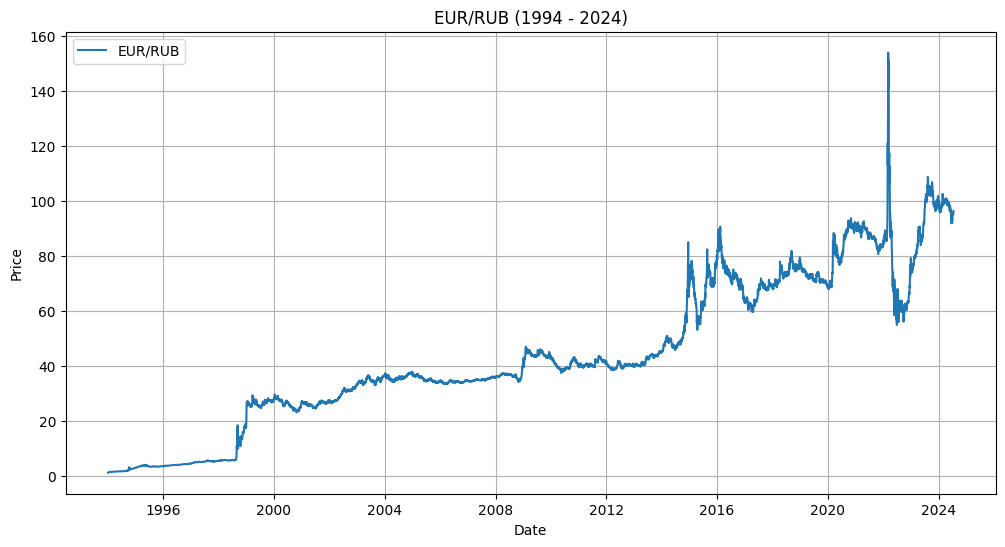

In [19]:
for col in filtered_data.columns:
    plot_variable(filtered_data, col)

## Gráficos das variáveis

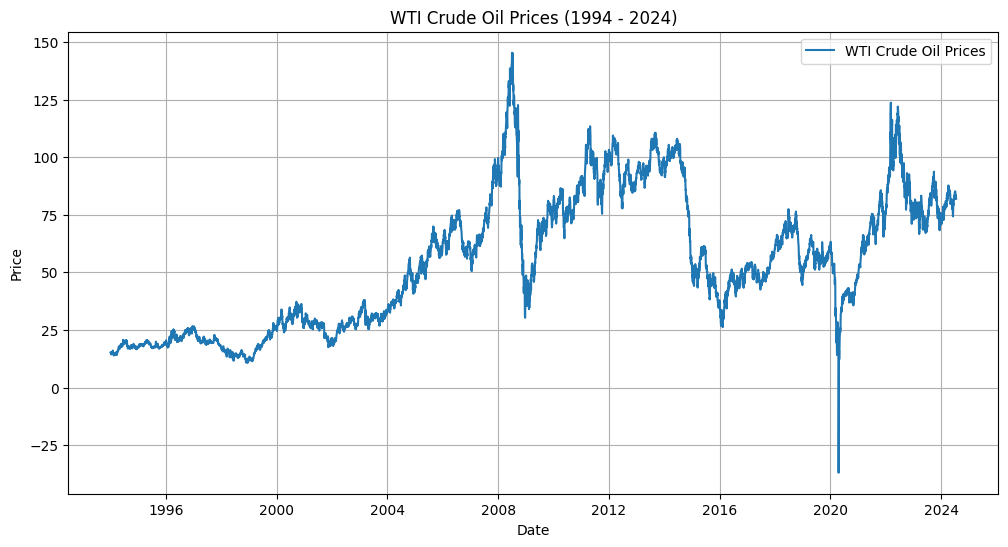

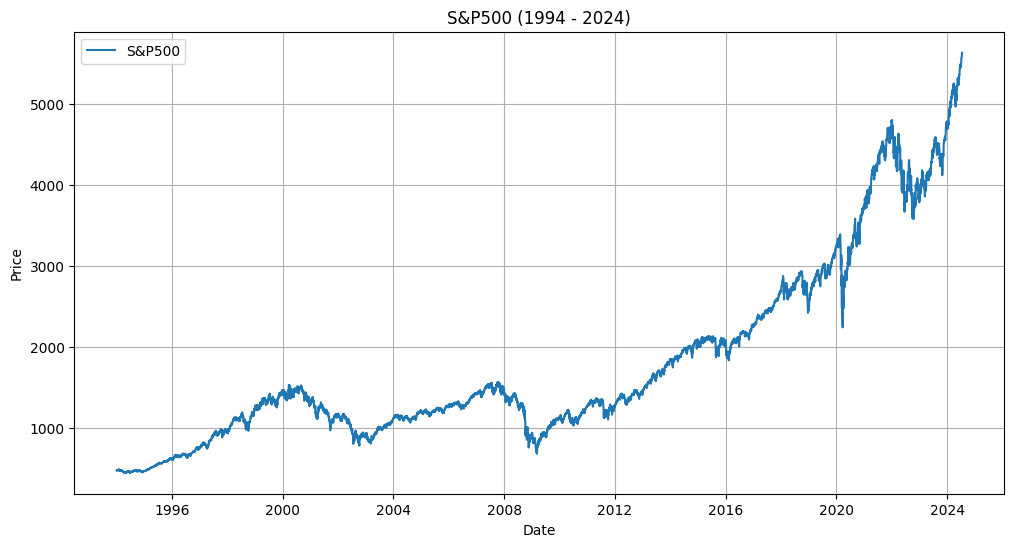

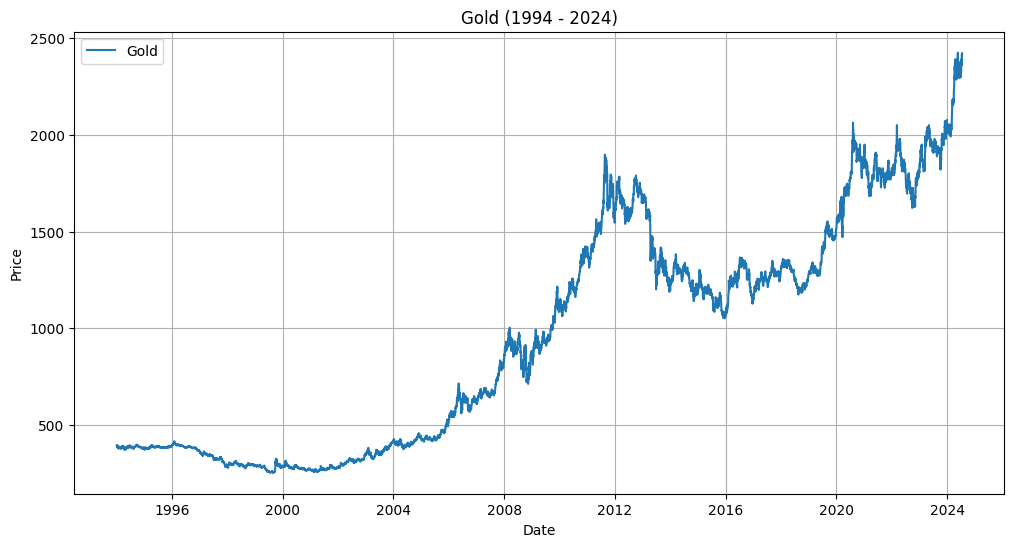

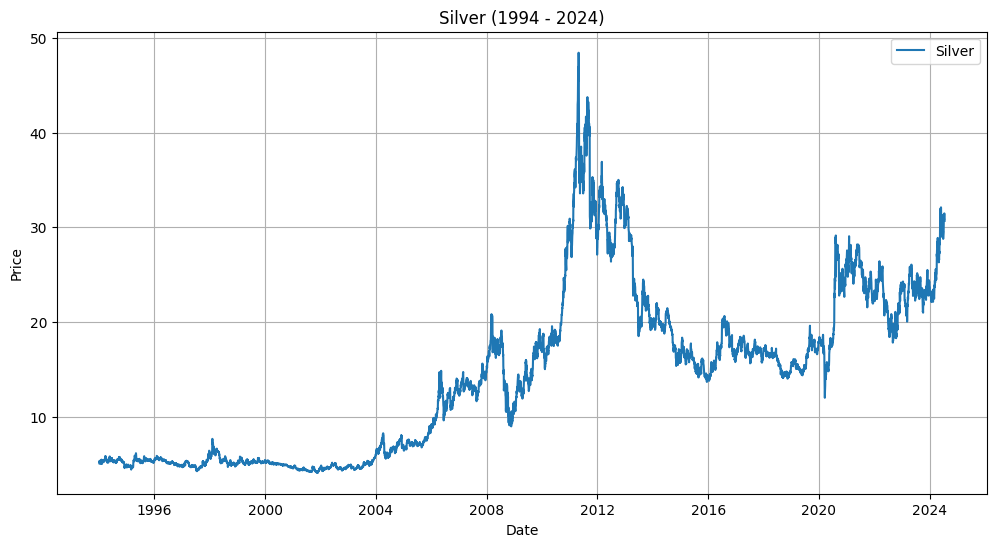

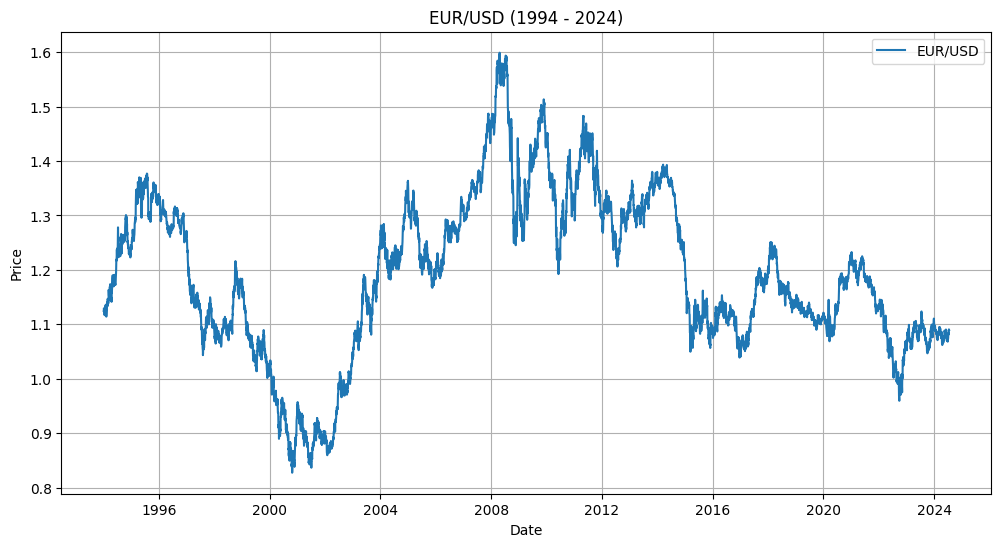

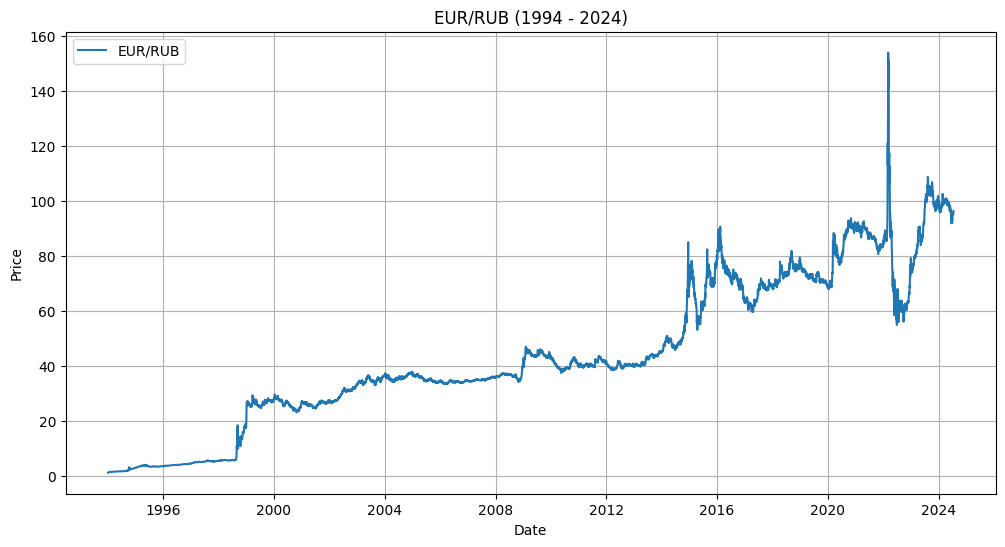

In [20]:
# Plotar gráficos para cada variável
variables = ['WTI Crude Oil Prices', 'S&P500', 'Gold', 'Silver', 'EUR/USD', 'EUR/RUB']
for var in variables:
    plot_variable(filtered_data, var)

## Describe das variáveis

In [21]:
# Descrever as variáveis
description = combined_data.describe()
print(tabulate(description, headers='keys', tablefmt='psql'))

+-------+----------+----------+------------+-------------+-----------+
|       |   S&P500 |     Gold |     Silver |     EUR/USD |   EUR/RUB |
|-------+----------+----------+------------+-------------+-----------|
| count |  7632    | 7632     | 7632       | 7632        | 7632      |
| mean  |  1804.36 |  960.037 |   14.2858  |    1.19132  |   44.1009 |
| std   |  1143.52 |  587.207 |    8.81784 |    0.148268 |   26.8347 |
| min   |   441.49 |  252.55  |    4.06    |    0.8272   |    1.1088 |
| 25%   |  1091.87 |  382.4   |    5.32    |    1.0915   |   27.3057 |
| 50%   |  1343.89 |  940.725 |   14.4855  |    1.1816   |   38.9201 |
| 75%   |  2191.3  | 1368.95  |   19.6331  |    1.30302  |   68.7176 |
| max   |  5631.22 | 2425.31  |   48.4438  |    1.5991   |  153.878  |
+-------+----------+----------+------------+-------------+-----------+


## Matriz de Correlação (Heatmap)

In [22]:
# Calcular a matriz de correlação
correlation_matrix = combined_data.corr()

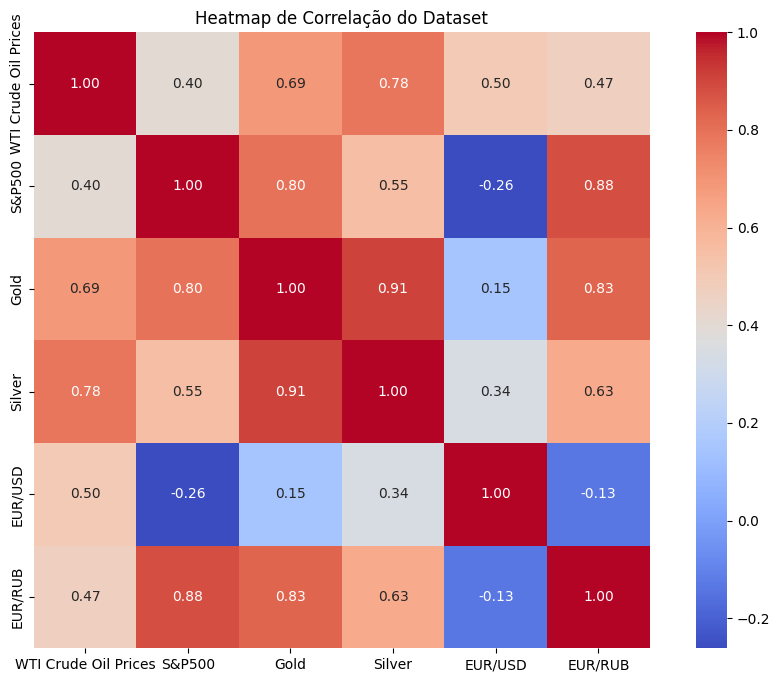

In [23]:
# Plotar o heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title('Heatmap de Correlação do Dataset')
plt.show()

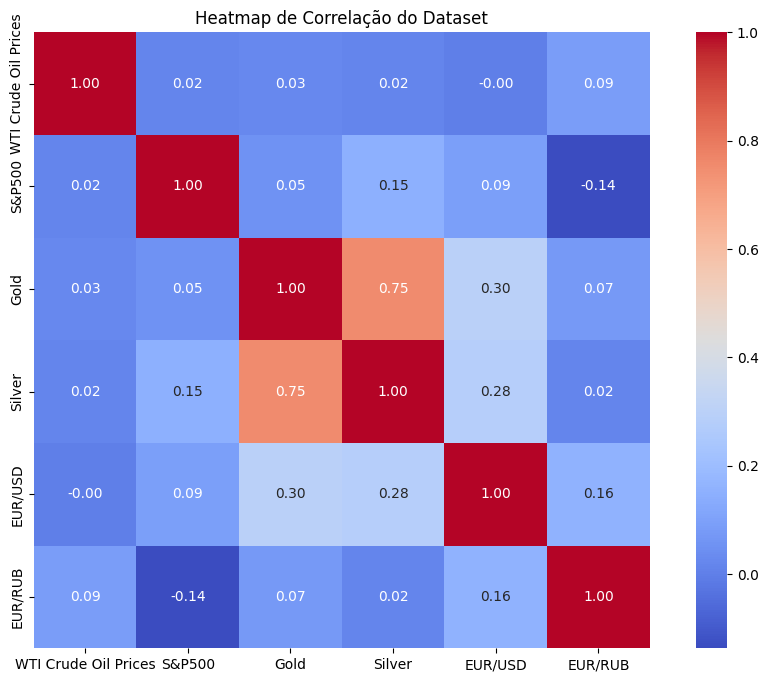

In [24]:
# Plotar o heatmap
correlation_matrix = dif_data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title('Heatmap de Correlação do Dataset')
plt.show()

# Modelagem

## Creating Features and Target Variables

A variável a estudar é o WTI Crude Oil, com preços 1994 a 2024, e vamos definir um único horizonte
temporal, h=1 ou seja, prever o preço do WTI para o dia seguinte, usando um daily dataframe e uma window_size de 30 dias.

## Train-Test Split

In [25]:
src_df = filtered_data.copy()

train_df = src_df.loc[:config["eval_range"][0]]
test_df = src_df.loc[config["eval_range"][0]:]

#scaled_data = X_scaler.fit_transform(filtered_data)
#scaled_y = y_scaler.fit_transform(filtered_data['WTI Crude Oil Prices'].values.reshape(-1, 1))

# train_df_enc = pd.DataFrame(data=X_scaler.fit_transform(train_df), columns=train_df.columns, index=train_df.index)
# train_df_enc.iloc[:,config["target_col"]] = y_scaler.fit_transform(train_df.iloc[:,config["target_col"]].values.reshape(-1, 1))


# test_df_enc = pd.DataFrame(data=X_scaler.transform(test_df), columns=test_df.columns, index=test_df.index)
# test_df_enc.iloc[:,config["target_col"]] = y_scaler.transform(test_df.iloc[:,config["target_col"]].values.reshape(-1, 1))

# train_df_enc = train_df
# test_df_enc = test_df

# scaled
Xha, yha, Ha = create_features_and_targets(train_df, config["MAX_HORIZON"], config["MAX_LAG"],  config["target_col"])
Xht, yht, Ht = create_features_and_targets(test_df, config["MAX_HORIZON"], config["MAX_LAG"],  config["target_col"])

assert Xha.shape[1] == Xht.shape[1], 'Erro no número de amostras de treino'

No train-test split usou-se um rácio de 80/20

In [26]:
# Treinar e avaliar os modelos
valid_models = {
    "Linear": {
        "callable": LinearRegression,
        "params": {},
        },
    "Ridge": {
        "callable": Ridge,
        "params": {"alpha": 0.01},
        },
    "Lasso": {
        "callable": Lasso,
        "params": {"alpha": 0.01},
        },
    "Elastic Net": {
        "callable": ElasticNet,
        "params": {"alpha": 0.01, "l1_ratio": 0.5},
        },
    "Random Forest": {
        "callable": RandomForestRegressor,
        "params": {
        },
        },
    "XGBoost": {
        "callable": XGBRegressor,
        "params": {},
        },
    "SVR": {
        "callable": SVR,
        "params": {"kernel": 'rbf'},
        }
}

# check that all models in config are valid
assert all(model in valid_models for model in config["models"]), 'Invalid models in config'

## Métricas usadas (RMSE, MAPE, R^2 e MSE)

In [27]:
import time

In [31]:
# filter models based on config
models = {k: v for k, v in valid_models.items() if k in config["models"]}

results = {horizon: {name: {} for name in models.keys()} for horizon in yha.keys()}
results2 = []

ScalerType = config["SCALER_TYPE"]

for window_size in config["window_sizes"]:

    Xha, yha, Ha = create_features_and_targets(train_df, config["MAX_HORIZON"], window_size,  config["target_col"])
    Xht, yht, Ht = create_features_and_targets(test_df, config["MAX_HORIZON"], window_size,  config["target_col"])

    for horizon in results.keys():
        X_train = Xha
        X_test = Xht
        y_train = yha[horizon]
        y_test = yht[horizon]
        for name, mdict in models.items():
            print(f"Window size={window_size} | H={horizon} | Model={name} | ", end="")

            # create the regressor model, add a scaling to X before feeding data to the model, add scaling to targets too
            model = mdict["callable"](**mdict["params"])
            pipeline = Pipeline([('scaler', ScalerType()), ('model', model)])
            final_model = TransformedTargetRegressor(regressor=pipeline, transformer=ScalerType())

            t_start = time.time()
            trained_model = final_model.fit(X_train, y_train)
            t_training = time.time() - t_start

            y_pred = final_model.predict(X_test)

            rmse = root_mean_squared_error(y_test, y_pred)
            mse = mean_squared_error(y_test, y_pred)
            mape = mean_absolute_percentage_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)

            res_dict = {
                "window_size": window_size,
                "horizon": horizon,
                "name": name,
                "model": final_model,
                "training_time": t_training,
                "RMSE": rmse,
                "MSE": mse,
                "MAPE": mape,
                "R2": r2,
                "y_pred": y_pred,
            }

            results[horizon][name] = res_dict
            results2.append(res_dict)
            
            print(f"Took {t_training:.2f} seconds | ", end="")
            # print metrics
            print(f"RMSE: {rmse:.2f}, MSE: {mse:.2f}, MAPE: {mape:.2f}, R2: {r2:.2f}")

# specifiy every model, add a key is_best if that model is the best in that horizon
for horizon in results.keys():
    best_model = min(results[horizon].keys(), key=lambda x: results[horizon][x]["RMSE"])
    results[horizon][best_model]["is_best"] = True

Window size=30 | H=0 | Model=Linear | Took 0.05 seconds | RMSE: 3.01, MSE: 9.07, MAPE: 0.03, R2: 0.98
Window size=30 | H=0 | Model=Ridge | Took 0.06 seconds | RMSE: 3.01, MSE: 9.06, MAPE: 0.03, R2: 0.98
Window size=30 | H=1 | Model=Linear | Took 0.09 seconds | RMSE: 3.77, MSE: 14.19, MAPE: 0.04, R2: 0.97
Window size=30 | H=1 | Model=Ridge | Took 0.06 seconds | RMSE: 3.76, MSE: 14.17, MAPE: 0.04, R2: 0.97
Window size=30 | H=2 | Model=Linear | Took 0.46 seconds | RMSE: 4.28, MSE: 18.28, MAPE: 0.05, R2: 0.96
Window size=30 | H=2 | Model=Ridge | Took 0.06 seconds | RMSE: 4.27, MSE: 18.27, MAPE: 0.05, R2: 0.96
Window size=30 | H=3 | Model=Linear | Took 0.09 seconds | RMSE: 4.67, MSE: 21.85, MAPE: 0.05, R2: 0.95
Window size=30 | H=3 | Model=Ridge | Took 0.05 seconds | RMSE: 4.67, MSE: 21.84, MAPE: 0.05, R2: 0.95
Window size=30 | H=4 | Model=Linear | Took 0.09 seconds | RMSE: 5.05, MSE: 25.53, MAPE: 0.06, R2: 0.95
Window size=30 | H=4 | Model=Ridge | Took 0.05 seconds | RMSE: 5.05, MSE: 25.52

# Modelos de Machine Learning

## Resultados

Inicialmente foram usados 4 modelos (Linear, Ridge, Lasso e Elastic Net Regressions) para testar o daily dataframe com h=1. Seguidamente, foram adicionados o Random Forest, XGBoost e o SVR com a RBF de Kernel.

In [32]:
metric_cols = ["horizon", "window_size", "name", "training_time", "RMSE", "MSE", "MAPE", "R2"]

res_df = pd.DataFrame(results2)
#res_df = res_df.reset_index()
#res_df.drop(columns=['model', "y_pred"], inplace=True)
res_df[metric_cols]

horizon  window_size    name  training_time      RMSE        MSE  \
0         0           30  Linear       0.053499  3.011728   9.070506   
1         0           30   Ridge       0.055690  3.009770   9.058715   
2         1           30  Linear       0.090005  3.766445  14.186109   
3         1           30   Ridge       0.056555  3.764447  14.171064   
4         2           30  Linear       0.457576  4.275584  18.280621   
..      ...          ...     ...            ...       ...        ...   
91       13           90   Ridge       0.224350  6.705296  44.960992   
92       14           90  Linear       0.220752  6.985637  48.799118   
93       14           90   Ridge       0.211214  6.983455  48.768650   
94       15           90  Linear       0.182749  7.243763  52.472108   
95       15           90   Ridge       0.147628  7.242152  52.448764   

        MAPE        R2  
0   0.030921  0.980755  
1   0.030886  0.980780  
2   0.040473  0.969886  
3   0.040445  0.969918  
4   0.047671  0.961179  
..       ...       ...  
91  0.071032  0.869246  
92  0.073583  0.857540  
93  0.073562  0.857629  
94  0.076343  0.846233  
95  0.076323  0.846302  

[96 rows x 8 columns]

In [60]:
print("best model by RMSE")
res_df.groupby('horizon').apply(lambda x: x[x['RMSE'] == x['RMSE'].min()])[metric_cols]

best model by RMSE


/tmp/ipykernel_541336/1837846485.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  res_df.groupby('horizon').apply(lambda x: x[x['RMSE'] == x['RMSE'].min()])[metric_cols]


horizon  window_size   name  training_time      RMSE        MSE  \
horizon                                                                       
0       1         0           15  Ridge       0.016007  2.822649   7.967348   
1       3         1           15  Ridge       0.036057  3.496126  12.222898   
2       5         2           15  Ridge       0.020383  3.959978  15.681424   
3       7         3           15  Ridge       0.012456  4.337339  18.812510   
4       9         4           15  Ridge       0.020852  4.689586  21.992216   
5       11        5           15  Ridge       0.019688  5.003183  25.031845   
6       13        6           15  Ridge       0.016388  5.266377  27.734727   
7       79        7           25  Ridge       0.018240  5.471981  29.942577   
8       81        8           25  Ridge       0.017660  5.711617  32.622566   
9       83        9           25  Ridge       0.020894  5.941742  35.304296   
10      85       10           25  Ridge       0.021941  6.111203  37.346803   
11      87       11           25  Ridge       0.019723  6.264132  39.239349   
12      57       12           20  Ridge       0.019727  6.451889  41.626868   
13      59       13           20  Ridge       0.022888  6.689264  44.746256   
14      61       14           20  Ridge       0.022557  6.896063  47.555687   
15      63       15           20  Ridge       0.017148  7.149905  51.121146   

                MAPE        R2  
horizon                         
0       1   0.027152  0.981223  
1       3   0.036390  0.971194  
2       5   0.042982  0.963045  
3       7   0.046811  0.955669  
4       9   0.052104  0.948179  
5       11  0.056834  0.941021  
6       13  0.060716  0.934658  
7       79  0.064075  0.929864  
8       81  0.066691  0.923584  
9       83  0.069970  0.917305  
10      85  0.073009  0.912522  
11      87  0.075270  0.908089  
12      57  0.077887  0.902266  
13      59  0.080328  0.894937  
14      61  0.083214  0.888333  
15      63  0.086024  0.879956

In [33]:
print("best model by R2")
res_df.groupby('horizon').apply(lambda x: x[x['R2'] == x['R2'].max()])[metric_cols]

best model by R2


/tmp/ipykernel_801874/1031507749.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  res_df.groupby('horizon').apply(lambda x: x[x['R2'] == x['R2'].max()])[metric_cols]


horizon  window_size   name  training_time      RMSE        MSE  \
horizon                                                                       
0       65        0           90  Ridge       0.205868  2.230064   4.973184   
1       67        1           90  Ridge       0.200951  3.134125   9.822737   
2       69        2           90  Ridge       0.248226  3.722777  13.859071   
3       7         3           30  Ridge       0.052742  4.673448  21.841116   
4       9         4           30  Ridge       0.052387  5.051469  25.517338   
5       11        5           30  Ridge       0.051748  5.371272  28.850559   
6       13        6           30  Ridge       0.067312  5.603700  31.401450   
7       15        7           30  Ridge       0.053764  5.818734  33.857671   
8       17        8           30  Ridge       0.059186  6.093132  37.126263   
9       19        9           30  Ridge       0.057077  6.336598  40.152471   
10      21       10           30  Ridge       0.079126  6.500174  42.252261   
11      23       11           30  Ridge       0.058539  6.639407  44.081729   
12      25       12           30  Ridge       0.060192  6.841224  46.802345   
13      27       13           30  Ridge       0.055256  7.057379  49.806594   
14      29       14           30  Ridge       0.044469  7.285268  53.075135   
15      31       15           30  Ridge       0.054243  7.550986  57.017389   

                MAPE        R2  
horizon                         
0       65  0.022750  0.986381  
1       67  0.031444  0.972935  
2       69  0.037937  0.961596  
3       7   0.051751  0.953600  
4       9   0.057326  0.945769  
5       11  0.062496  0.938652  
6       13  0.066533  0.933189  
7       15  0.070399  0.927912  
8       17  0.073913  0.920889  
9       19  0.077199  0.914348  
10      21  0.080632  0.909785  
11      23  0.082734  0.905791  
12      25  0.085061  0.899882  
13      27  0.086686  0.893344  
14      29  0.088889  0.886164  
15      31  0.092058  0.877331

## Tabelas c/ modelos, horizontes e métricas

# Previsões

In [34]:
# Função para plotar previsões vs valores reais com valores desescalados
def plot_predictions(y_test, y_pred, model_name, horizon, x_axis=None):
    # y_test_descaled = inverse_transform(y_scaler, np.zeros((y_test.shape[0], scaled_data.shape[1] - 1)), y_test)
    # y_pred_descaled = inverse_transform(y_scaler, np.zeros((y_pred.shape[0], scaled_data.shape[1] - 1)), y_pred)
    
    plt.figure(figsize=(12, 6))
    if x_axis is None:
        x_axis = range(len(y_test))
    plt.plot(x_axis, y_test, label='True', color='blue')
    plt.plot(x_axis, y_pred, label=model_name, color='orange')
    plt.title(f'Predição do modelo {model_name} para horizonte de {horizon} dias')
    plt.xlabel('Observations')
    plt.ylabel('WTI Crude Oil Prices')
    plt.legend()
    plt.grid(True)
    plt.show()

# Modelos horizontes -> predição mensal

In [35]:
best_by_rmse = res_df.iloc[res_df.groupby('horizon')['RMSE'].idxmin()][["horizon", "window_size", "model"]]

# filter best models
best_models = {horizon: (window_size, model) for (_, (horizon, window_size, model)) in best_by_rmse.iterrows()}

#[id(m[1]) for m in best_models.values()]

In [36]:
eval_start_date = '2021-01-01'
eval_end_date = '2024-06-01'
eval_range = src_df.loc[eval_start_date:eval_end_date].index

# remove days after day X
eval_range = eval_range[eval_range.day < 20]

# group time index by year and month
wed_range = eval_range[eval_range.weekday == 2]

wed_df = pd.DataFrame(index=eval_range, data={'year': eval_range.year, 'month': eval_range.month})

range_business_days = pd.date_range(start=eval_start_date, end=eval_end_date, freq='B')


In [37]:
def day_to_month_prices(x: pd.Series):
    """
    Daily prices to monthly average price and also previous monthly average price.
    May loose days at the beginning of the series
    """
    avg = x.resample('ME').transform('mean')
    prev_avg = avg.resample("ME").last().shift(1).resample('D').bfill().dropna()

    start_date = prev_avg.index[0]
    end_date = avg.index[-1]

    avg = avg.loc[start_date:end_date]
    prev_avg = prev_avg.loc[avg.index]

    # change series name
    avg.name = 'Monthly Average'
    prev_avg.name = 'Previous Month Average'

    return avg, prev_avg

def get_nth_wed(start, end, n):
    dt_range = pd.date_range(start=start, end=end, freq='B')
    wed_mask = dt_range.weekday == 2
    wed_df = pd.DataFrame(index=dt_range[wed_mask], data={'year': dt_range.year[wed_mask], 'month': dt_range.month[wed_mask], 'day': dt_range.day[wed_mask]})
    return wed_df.groupby(['year', 'month']).nth(n).index

def filter_nth_wed(df, n):
    dt_index = get_nth_wed(df.index[0], df.index[-1], n)
    return df.loc[dt_index]

def create_decision_array(monthly_price, prev_monthly_price):
    '''
    pd.Series with timestamp index and monthly average price as values
    The decision is True if, 
    '''
    return monthly_price > prev_monthly_price

def simulate_decisions(decision: pd.Series, price_when_buying: pd.Series):
    """
    Each month we consume monthly_volume of oil.
    We can store fuel for 1 month.
    If decision is 1 (buy), we buy for the following month.
    If decision is 0, we do not buy for the follwing month.
    If there has been no purchase for the current month, we also buy for the current month.
    check if there has been any purchase for the current month.
    """
    
    bought_when = [None] * len(decision)
    bought_at_price = price_when_buying.copy()
    bought_at_price.iloc[:] = 0

    bought_at_price.iloc[0] = price_when_buying.iloc[0]
    bought_when[0] = 'this month'

    for i in range(0, len(decision)-1):
        # if this month has not been bought yet, buy
        if bought_at_price.iloc[i] == 0:
            bought_at_price.iloc[i] = price_when_buying.iloc[i]
            bought_when[i] = 'this month'
        
        # if decision is to buy, buy for next month 
        if decision.iloc[i] == 1:
            bought_at_price.iloc[i+1] = price_when_buying.iloc[i]
            bought_when[i+1] = 'last month'

    # check the last month, if it has not been bought in advance, buy
    if bought_at_price.iloc[-1] == 0:
        bought_at_price.iloc[-1] = price_when_buying.iloc[-1]
        bought_when[-1] = 'this month'


    return bought_at_price, pd.Series(bought_when, index=decision.index, name='bought_when')

In [38]:
eval_start_date = config["eval_range"][0]
eval_end_date = config["eval_range"][1]
eval_range = src_df.loc[eval_start_date:eval_end_date].index

wed_mask = filtered_data.index.weekday == 2
test_mask = (filtered_data.index > '2020-01-01') & (filtered_data.index < '2024-06-01') & wed_mask

# y_avg = src_df['WTI Crude Oil Prices'].resample('ME').transform('mean')
# y_avg = y_avg.loc[eval_range]


y_avg_hat = []
valid_pred_days = []

y_avg_hat_dumb = []
for day in src_df.loc[eval_range].index:
    
    try:
        y_avg_hat_ = predict_month_avg(best_models, src_df, day, target_column=config["target_col"])
        y_avg_hat_ = predict_month_avg(best_models, src_df, day, target_column=config["target_col"])
        y_avg_hat.append(y_avg_hat_)
        valid_pred_days.append(day)

        month_begins = day.replace(day=1)
        y_avg_hat_dumb_ = src_df.loc[month_begins:day]['WTI Crude Oil Prices'].mean()
        y_avg_hat_dumb.append(y_avg_hat_dumb_)
    except:
        #print(f"Error predicting for {day}")
        continue

y_avg, prev_avg = day_to_month_prices(src_df['WTI Crude Oil Prices'])
y_avg = y_avg.loc[eval_range]
prev_avg = prev_avg.loc[eval_range]

y_avg_df = pd.DataFrame(data={'y_avg': y_avg, 'y_avg_hat': y_avg_hat, "y_avg_dumb": y_avg_hat_dumb}, index=valid_pred_days)


prev_avg = prev_avg.loc[y_avg_df.index]

y_avg_df["avg_prev"] = prev_avg
y_avg_df["y_decision"] = create_decision_array(y_avg_df['y_avg'], prev_avg)
y_avg_df["y_hat_decision"] = create_decision_array(y_avg_df['y_avg_hat'], prev_avg)
y_avg_df["y_dumb_decision"] = create_decision_array(y_avg_df['y_avg_dumb'], prev_avg)

y_avg_df

/home/dasilva/workspace/lamelas/smart_fuel_acquisitons/data.py:148: UserWarning: Expected future date range is different from fetched data. The first different dates are 2020-01-20 00:00:00 vs. 2020-01-17 00:00:00.
  warnings.warn(f'Expected future date range is different from fetched data. The first different dates are {expected} vs. {fetched}.')
/home/dasilva/workspace/lamelas/smart_fuel_acquisitons/data.py:129: UserWarning: Expected date range is different from fetched data. The first different dates are 2020-01-01 00:00:00 vs. 2019-12-31 00:00:00.
  warnings.warn(f'Expected date range is different from fetched data. The first different dates are {expected} vs. {fetched}.')
/home/dasilva/workspace/lamelas/smart_fuel_acquisitons/data.py:129: UserWarning: Expected date range is different from fetched data. The first different dates are 2020-01-01 00:00:00 vs. 2019-12-31 00:00:00.
  warnings.warn(f'Expected date range is different from fetched data. The first different dates are {expec

y_avg  y_avg_hat  y_avg_dumb   avg_prev  y_decision  \
2020-01-13      56.99  58.478255   60.463750  60.064286       False   
2020-01-14      56.99  58.896675   60.174444  60.064286       False   
2020-01-15      56.99  58.794965   60.009000  60.064286       False   
2020-01-16      56.99  59.355856   59.876364  60.064286       False   
2020-01-17      56.99  58.882706   59.740833  60.064286       False   
...               ...        ...         ...        ...         ...   
2024-05-24  79.738571  79.920943   80.122353  85.172727       False   
2024-05-28  79.738571  80.314944   80.128889  85.172727       False   
2024-05-29  79.738571  80.103599   80.067368  85.172727       False   
2024-05-30  79.738571  79.851900   79.962500  85.172727       False   
2024-05-31  79.738571  79.624931   79.738571  85.172727       False   

            y_hat_decision  y_dumb_decision  
2020-01-13           False             True  
2020-01-14           False             True  
2020-01-15           False            False  
2020-01-16           False            False  
2020-01-17           False            False  
...                    ...              ...  
2024-05-24           False            False  
2024-05-28           False            False  
2024-05-29           False            False  
2024-05-30           False            False  
2024-05-31           False            False  

[763 rows x 7 columns]

In [39]:
print("Dumb prediction model error:", mean_squared_error(y_avg_df['y_avg'], y_avg_df['y_avg_dumb']))
print("Predictive model error:", mean_squared_error(y_avg_df['y_avg'], y_avg_df['y_avg_hat']))

# accuracy for the predictive model and the dumb model
print("Dumb prediction model accuracy:", (y_avg_df['y_decision'] == y_avg_df['y_dumb_decision']).mean())
print("Predictive model accuracy:", (y_avg_df['y_decision'] == y_avg_df['y_hat_decision']).mean())

print("Number of different decisions from dumb to pred:", (y_avg_df['y_hat_decision'] != y_avg_df['y_dumb_decision']).sum())

Dumb prediction model error: 2.788843858576439
Predictive model error: 2.6682774966029235
Dumb prediction model accuracy: 0.9685452162516383
Predictive model accuracy: 0.9606815203145478
Number of different decisions from dumb to pred: 26


In [40]:
y_avg_wed_df = filter_nth_wed(y_avg_df, -1)
# compute errors
print("Dumb prediction model error:", mean_squared_error(y_avg_wed_df['y_avg'], y_avg_wed_df['y_avg_dumb']))
print("Predictive model error:", mean_squared_error(y_avg_wed_df['y_avg'], y_avg_wed_df['y_avg_hat']))

# accuracy for the predictive model and the dumb model
print("Dumb prediction model accuracy:", (y_avg_wed_df['y_decision'] == y_avg_wed_df['y_dumb_decision']).mean())
print("Predictive model accuracy:", (y_avg_wed_df['y_decision'] == y_avg_wed_df['y_hat_decision']).mean())

# number of different decisions from dumb to pred
print("Number of different decisions from dumb to pred:", (y_avg_wed_df['y_hat_decision'] != y_avg_wed_df['y_dumb_decision']).sum())

Dumb prediction model error: 0.2496587730150906
Predictive model error: 0.12492773857887526
Dumb prediction model accuracy: 0.9811320754716981
Predictive model accuracy: 1.0
Number of different decisions from dumb to pred: 1


In [41]:
y_avg_wed_df = filter_nth_wed(y_avg_df, -2)
# compute errors
print("Dumb prediction model error:", mean_squared_error(y_avg_wed_df['y_avg'], y_avg_wed_df['y_avg_dumb']))
print("Predictive model error:", mean_squared_error(y_avg_wed_df['y_avg'], y_avg_wed_df['y_avg_hat']))

# accuracy for the predictive model and the dumb model
print("Dumb prediction model accuracy:", (y_avg_wed_df['y_decision'] == y_avg_wed_df['y_dumb_decision']).mean())
print("Predictive model accuracy:", (y_avg_wed_df['y_decision'] == y_avg_wed_df['y_hat_decision']).mean())

print("Number of different decisions from dumb to pred:", (y_avg_wed_df['y_hat_decision'] != y_avg_wed_df['y_dumb_decision']).sum())

Dumb prediction model error: 1.9271040554623877
Predictive model error: 1.24898336583248
Dumb prediction model accuracy: 0.9811320754716981
Predictive model accuracy: 0.9622641509433962
Number of different decisions from dumb to pred: 1


In [42]:
y_avg_wed_df = filter_nth_wed(y_avg_df, -2)

best_scenario, best_when = simulate_decisions(y_avg_wed_df["y_decision"], y_avg_wed_df["avg_prev"])
pred_scenario, pred_when = simulate_decisions(y_avg_wed_df["y_hat_decision"], y_avg_wed_df["avg_prev"])
dumb_scenario, dumb_when = simulate_decisions(y_avg_wed_df["y_dumb_decision"], y_avg_wed_df["avg_prev"])
dumb_dumb_scenario = y_avg_wed_df["avg_prev"]
dumb_dumb_when = pd.Series(['this month'] * len(y_avg_wed_df), index=y_avg_wed_df.index, name='bought_when')

scenarios_df = pd.DataFrame(data={'best': best_scenario, 'pred': pred_scenario, 'dumb': dumb_scenario, 'dumb_dumb': dumb_dumb_scenario}, index=y_avg_wed_df.index)
# add bought when
scenarios_df['best_when'] = best_when
scenarios_df['pred_when'] = pred_when
scenarios_df['dumb_when'] = dumb_when
scenarios_df['dumb_dumb_when'] = dumb_dumb_when
scenarios_df

best        pred        dumb   dumb_dumb   best_when  \
2020-01-22   60.064286   60.064286   60.064286   60.064286  this month   
2020-02-19       56.99       56.99       56.99       56.99  this month   
2020-03-18       50.37       50.37       50.37       50.37  this month   
2020-04-22   28.003182   28.003182   28.003182   28.003182  this month   
2020-05-20   16.520952   16.520952   16.520952   16.520952  this month   
2020-06-17   16.520952   16.520952   16.520952      29.351  last month   
2020-07-22      29.351      29.351      29.351   38.506818  last month   
2020-08-19   38.506818   38.506818   38.506818   40.753636  last month   
2020-09-23   40.753636   40.753636   40.753636   42.430952  last month   
2020-10-21   39.431905   39.431905   39.431905   39.431905  this month   
2020-11-18   39.309091   39.431905   39.431905   39.309091  this month   
2020-12-23   39.309091   39.309091   39.309091   41.355263  last month   
2021-01-20   41.355263   41.355263   41.355263   47.158182  last month   
2021-02-17   47.158182   47.158182   47.158182   52.328421  last month   
2021-03-24   52.328421   52.328421   52.328421   59.414211  last month   
2021-04-21   59.414211   59.414211   59.414211    62.37087  last month   
2021-05-19   61.861905   61.861905   61.861905   61.861905  this month   
2021-06-23   61.861905   61.861905   61.861905     65.3365  last month   
2021-07-21     65.3365     65.3365     65.3365   71.720455  last month   
2021-08-18   71.720455    72.29381   71.720455    72.29381  last month   
2021-09-22   67.608636   67.608636   67.608636   67.608636  this month   
2021-10-20   67.608636   67.608636   67.608636   71.997619  last month   
2021-11-17   71.997619   71.997619   71.997619   81.860952  last month   
2021-12-22     78.2155     78.2155     78.2155     78.2155  this month   
2022-01-19   72.191364   72.191364   72.191364   72.191364  this month   
2022-02-16   72.191364   72.191364   72.191364     83.8335  last month   
2022-03-23     83.8335     83.8335     83.8335   92.453684  last month   
2022-04-20   92.453684   92.453684   92.453684  108.313913  last month   
2022-05-18    102.0705    102.0705    102.0705    102.0705  this month   
2022-06-22    102.0705    102.0705    102.0705  110.032381  last month   
2022-07-20  110.032381  110.032381  110.032381  114.600952  last month   
2022-08-24    100.9335    100.9335    100.9335    100.9335  this month   
2022-09-21   93.252174   93.252174   93.252174   93.252174  this month   
2022-10-19   84.113333   84.113333   84.113333   84.113333  this month   
2022-11-23   84.113333   84.113333   84.113333       87.76  last month   
2022-12-21   84.022857   84.022857   84.022857   84.022857  this month   
2023-01-18   76.237619   76.237619   76.237619   76.237619  this month   
2023-02-15   76.237619   76.237619   76.237619     78.0965  last month   
2023-03-22   76.897368   76.897368   76.897368   76.897368  this month   
2023-04-19    73.40087    73.40087    73.40087    73.40087  this month   
2023-05-24    73.40087    73.40087    73.40087   79.196316  last month   
2023-06-21   71.325455   71.325455   71.325455   71.325455  this month   
2023-07-19       70.23       70.23       70.23       70.23  this month   
2023-08-23       70.23       70.23       70.23     76.6525  last month   
2023-09-20     76.6525     76.6525     76.6525   81.566522  last month   
2023-10-18   81.566522   81.566522   81.566522     89.5895  last month   
2023-11-22       85.27       85.27       85.27       85.27  this month   
2023-12-20     77.3175     77.3175     77.3175     77.3175  this month   
2024-01-24   71.611053   71.611053   71.611053   71.611053  this month   
2024-02-21   71.611053   71.611053   71.611053   74.330476  last month   
2024-03-20   74.330476   74.330476   74.330476      77.576  last month   
2024-04-17      77.576      77.576      77.576       81.46  last month   
2024-05-22       81.46       81.46       81.46   85.172727  last month   

             pred_whe

O modelo de decisão é baseado na compra do combustível do mês seguinte, se o preço médio do mês corrente for superior ao do mês anterior
O preço médio do mês corrente será o preço do próximo mês, logo se o preço médio do mês corrente for superior ao do mês anterior, o preço do próximo mês será superior ao preço actual, logo faz sentido adquirir em avançado.

- "best" - é o melhor modelo tendo em conta o valor médio verdadeiro (observado).
- "pred" - é o modelo com base nos valor médio previsto pelos modelos
- "dumb" - é o modelo em que o modelo de previsão é simplesmente a média dos valores observados até ao momento.
- "dumb_dumb" - é o modelo em que não se compra em avançado

In [43]:
print("""Diferença percentual para o modelo \"dumb_dumb\":""")

- (scenarios_df["dumb_dumb"].sum() - scenarios_df[["best", "pred", "dumb", "dumb_dumb"]].sum()) / scenarios_df["dumb_dumb"].sum() * 100

Diferença percentual para o modelo "dumb_dumb":


best        -4.458949
pred        -4.440309
dumb        -4.455661
dumb_dumb        -0.0
dtype: object